---
**License**

 BounceVecPert

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 BounceVecPert\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from IPython.display import HTML

from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
%matplotlib inline

# Figure utilities

In [2]:
fig_width_pt  = 246.0 * 2.0                 # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27                 # Convert pt to inch
golden_mean   = (math.sqrt (5) - 1.0) / 2.0 # Aesthetic ratio
fig_width     = fig_width_pt*inches_per_pt  # width in inches
fig_height    = fig_width*golden_mean       # height in inches
fig_size      = [ fig_width, fig_height ]

params = {
          'axes.labelsize' : 10,
          'font.size'      : 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex'    : True,
          'figure.figsize' : fig_size,
          'animation.embed_limit' : 2**128
         }

mpl.rcParams.update (params)

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base == 1.0:
          if exponent == 0.0:
            return r"1"
          else:
            return r"10^{{{1}}}".format (int(exponent))
        elif exponent == 0.0:
          return r"{0}".format (base)
        else:
          return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

# Initializing the library

In [3]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# Complex structure quantization object

Below we define our object as a child of the complex structure quantization object Ncm.CSQ1D

In [4]:
csq1d = Nc.DECont (Omegaw = 0.3, OmegaL = 0.7, w = 1.0e-1, cs2 = 1.0e-1)

ti = 1.0e-8
tf = 1.0e10

ki    = 1.0e0
kf    = 1.0e3
k_a   = np.geomspace (ki, kf, 1000)

k = kf
csq1d.set_k (k)
csq1d.prepare_prop (None, 0.0, 1.0e-30, 1.0e1)

mylw = 1.0

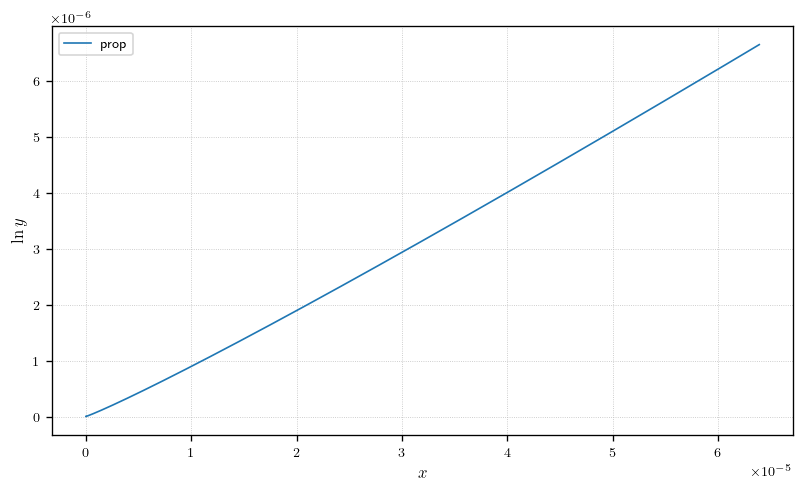

In [5]:
def logcosh(x):
    # s always has real part >= 0
    s = np.sign(x) * x
    p = np.exp(-2 * s)
    return s + np.log1p(p) - np.log(2)

def get_chi_Up_V(t,k):
    q0 = csq1d.eval_int_1_m (None, t, k)
    q1 = csq1d.eval_int_q2mnu2 (None, t, k)
    p1 = csq1d.eval_int_qmnu2 (None, t, k)
    r1 = 0.5 * csq1d.eval_int_mnu2 (None, t, k)
    q  = q0 + q1

    chi = (math.sinh (2.0 * r1) - q * math.exp (-2.0 * p1) * math.cosh (2.0 * r1))
    Up  = (-2.0 * p1 + logcosh (2.0 * r1))
    
    return chi, Up

chi_i, Up_i = get_chi_Up_V (ti,k)

tf = 1.0e-4

csq1d.set_init_cond (Ncm.CSQ1DEvolState.UP, ti, chi_i, Up_i)

csq1d.prepare ()

N = 2000

t_a, t_s = csq1d.get_time_array ()
t_a = np.array (t_a)
   
t_a = np.geomspace (ti, tf, N)

x_a        = []
lny_a      = []
x_prop_a   = []
lny_prop_a = []
x_V_a      = []
lny_V_a    = []

    
for t in t_a:
    (x, lny)  = csq1d.get_poincare_hp (None, t)
    (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, 2, 0.0, 0.0)
    q0 = csq1d.eval_int_1_m (None, t, k)
    q1 = csq1d.eval_int_q2mnu2 (None, t, k)
    p1 = -csq1d.eval_int_qmnu2 (None, t, k)
    r1 = 0.5 * csq1d.eval_int_mnu2 (None, t, k)
    q = q0 + q1 * 0.0

    x = x + q
  
    #x = x * math.exp (-2.0 * p1)
    #lny = lny - 2.0 * p1

    #x = x + (x**2 - math.exp(2.0 * lny) - 1.0) * r1
    #lny = lny + math.log(1.0 + 2.0 * x * r1)
  
    x_a.append (x)
    lny_a.append (lny)

    x_prop_a.append (chi / math.exp (Up))
    lny_prop_a.append (-Up)
    
    chi_V, Up_V = get_chi_Up_V (t, k)
    
    x_V_a.append (chi_V / math.exp (Up_V) + q)
    lny_V_a.append (-Up_V)
    
fig = plt.figure (dpi = 120)

#plt.plot (x_a, lny_a, lw=mylw, label = r'no-prop')
plt.plot (x_prop_a, lny_prop_a, lw=mylw, label = r'prop')
#plt.plot (x_V_a, lny_V_a, lw=mylw, label = r'V')

plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)

plt.xlabel ("$x$")
plt.ylabel ("$\ln y$")

fig.tight_layout ()

plt.show



pass

0.02501234153784666 0.0023809523809523434 0.00011593119358671512 2.501234153784666e-10 2.3809523809523433e-11


<function matplotlib.pyplot.show(close=None, block=None)>

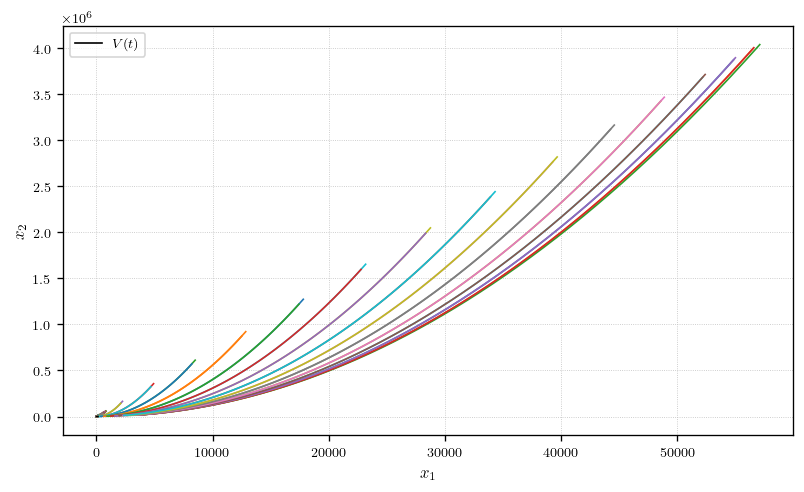

In [6]:
tf = 1.0e-4

N = 2000
   
t_a = np.geomspace (ti, tf, N)

fig = plt.figure (dpi=120)

frame = 0

x0_a   = []
lny0_a = []

chiV = 0.0
UpV = 0.0

gammaV = UpV - 0.5 * math.log1p (chiV * chiV)
alphaV = math.asinh (chiV)
                
for t in t_a:
    (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chiV, UpV)
    
    x0_a.append (chi / math.exp (Up))
    lny0_a.append (-Up)

x0_a = np.array (x0_a)
lny0_a = np.array (lny0_a)

for r in np.geomspace (1.0e-4, 6.0e0, 10):
    for theta in np.linspace (0.0, 2.0 * math.pi, 2*16, endpoint=False):
        x_a   = []
        lny_a = []
                
        alpha0, gamma0 = csq1d.alpha_gamma_circle (None, alphaV, gammaV, r, theta)
  
        chi0 = math.sinh (alpha0)
        Up0  = gamma0 + 0.5 * math.log1p (chi0 * chi0)

        #print (r, theta, chi0, Up0)

        for t in t_a:
            (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chi0, Up0)
            #x_a.append (chi / math.exp (Up))
            #lny_a.append (-Up)
            gamma = Up - 0.5 * math.log1p (chi*chi) 
            x_a.append (chi)
            lny_a.append (-math.sqrt (1.0 + chi * chi) * math.sinh (gamma))
        
        x_a = np.array (x_a)
        lny_a = np.array (lny_a)
        
        #x_a   = (x_a - x0_a) * np.exp (-lny0_a)
        #lny_a = lny_a - lny0_a
        
        #print (x_a)
        #print (lny_a)
        
        plt.plot (x_a, lny_a, lw=mylw)

plt.plot (x0_a, lny0_a, lw=mylw, c='k', label = r'$V(t)$')

q1 = csq1d.eval_int_q2mnu2 (None, tf, k)
p1 = -csq1d.eval_int_qmnu2 (None, tf, k)
r1 = 0.5 * csq1d.eval_int_mnu2 (None, tf, k)

print (q1, p1, r1, q1*tf**2, p1*tf**2)    
        
plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)
#plt.xscale("symlog", linthresh=1.0e1)
#plt.yscale("symlog", linthresh=1.0e1)

plt.xlabel ("$x_1$")
plt.ylabel ("$x_2$")

#plt.axis('equal')
fig.tight_layout ()

plt.savefig ("nonadiab_vacuum_f0.pdf")
plt.show

0.02501234153784666 0.0023809523809523434 0.00011593119358671512 2.501234153784666e-10 2.3809523809523433e-11


<function matplotlib.pyplot.show(close=None, block=None)>

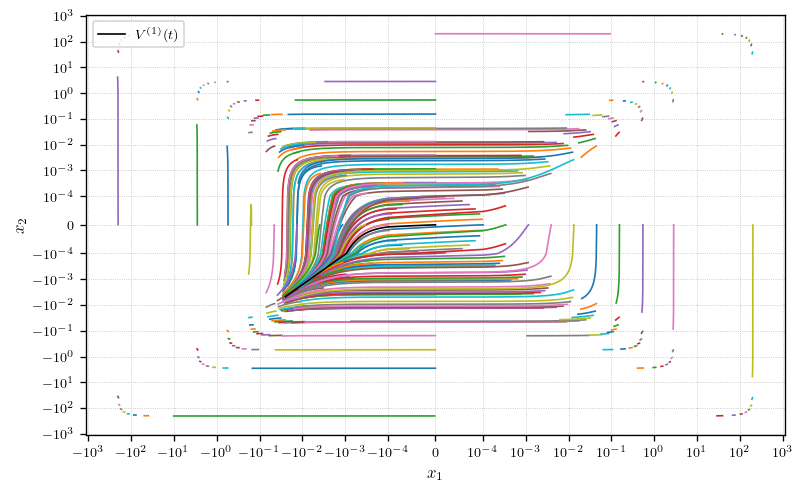

In [7]:
tf = 1.0e-4

N = 2000
   
t_a = np.geomspace (ti, tf, N)

fig = plt.figure (dpi=120)

frame = 1

x0_a   = []
lny0_a = []

chiV = 0.0
UpV = 0.0

gammaV = UpV - 0.5 * math.log1p (chiV * chiV)
alphaV = math.asinh (chiV)
                
for t in t_a:
    (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chiV, UpV)
    
    x0_a.append (chi / math.exp (Up))
    lny0_a.append (-Up)

x0_a = np.array (x0_a)
lny0_a = np.array (lny0_a)

for r in np.geomspace (1.0e-4, 6.0e0, 10):
    for theta in np.linspace (0.0, 2.0 * math.pi, 2*16, endpoint=False):
        x_a   = []
        lny_a = []
                
        alpha0, gamma0 = csq1d.alpha_gamma_circle (None, alphaV, gammaV, r, theta)
  
        chi0 = math.sinh (alpha0)
        Up0  = gamma0 + 0.5 * math.log1p (chi0 * chi0)

        #print (r, theta, chi0, Up0)

        for t in t_a:
            (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chi0, Up0)
            #x_a.append (chi / math.exp (Up))
            #lny_a.append (-Up)
            gamma = Up - 0.5 * math.log1p (chi*chi) 
            x_a.append (chi)
            lny_a.append (-math.sqrt (1.0 + chi * chi) * math.sinh (gamma))
        
        x_a = np.array (x_a)
        lny_a = np.array (lny_a)
        
        #x_a   = (x_a - x0_a) * np.exp (-lny0_a)
        #lny_a = lny_a - lny0_a
        
        #print (x_a)
        #print (lny_a)
        
        plt.plot (x_a, lny_a, lw=mylw)

plt.plot (x0_a, lny0_a, lw=mylw, c='k', label = r'$V^{(1)}(t)$')
q1 = csq1d.eval_int_q2mnu2 (None, tf, k)
p1 = -csq1d.eval_int_qmnu2 (None, tf, k)
r1 = 0.5 * csq1d.eval_int_mnu2 (None, tf, k)
        

print (q1, p1, r1, q1*tf**2, p1*tf**2)    
        
plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="upper left", ncol = 2)
plt.xscale("symlog", linscale=1.0e0, linthresh=1.0e-4)
plt.yscale("symlog", linscale=1.0e0, linthresh=1.0e-4)

plt.xlabel ("$x_1$")
plt.ylabel ("$x_2$")

#plt.axis('equal')
fig.tight_layout ()

plt.savefig ("nonadiab_vacuum_f1.pdf")
plt.show

0.02501234153784666 0.0023809523809523434 0.00011593119358671512 2.501234153784666e-10 2.3809523809523433e-11


<function matplotlib.pyplot.show(close=None, block=None)>

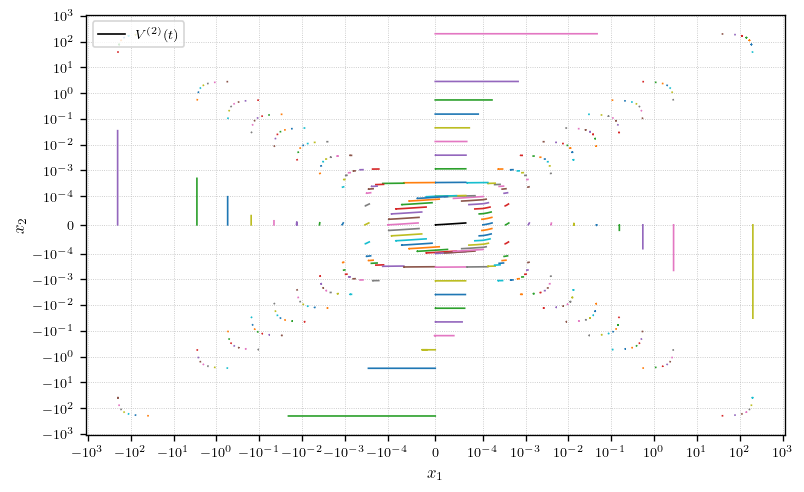

In [8]:
tf = 1.0e-4

N = 2000
   
t_a = np.geomspace (ti, tf, N)

fig = plt.figure (dpi=120)

frame = 2

x0_a   = []
lny0_a = []

chiV = 0.0
UpV = 0.0

gammaV = UpV - 0.5 * math.log1p (chiV * chiV)
alphaV = math.asinh (chiV)
                
for t in t_a:
    (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chiV, UpV)
    
    x0_a.append (chi / math.exp (Up))
    lny0_a.append (-Up)

x0_a = np.array (x0_a)
lny0_a = np.array (lny0_a)

for r in np.geomspace (1.0e-4, 6.0e0, 10):
    for theta in np.linspace (0.0, 2.0 * math.pi, 2*16, endpoint=False):
        x_a   = []
        lny_a = []
                
        alpha0, gamma0 = csq1d.alpha_gamma_circle (None, alphaV, gammaV, r, theta)
  
        chi0 = math.sinh (alpha0)
        Up0  = gamma0 + 0.5 * math.log1p (chi0 * chi0)

        #print (r, theta, chi0, Up0)

        for t in t_a:
            (chi, Up) = csq1d.evolve_prop_vector_chi_Up (None, t, frame, chi0, Up0)
            #x_a.append (chi / math.exp (Up))
            #lny_a.append (-Up)
            gamma = Up - 0.5 * math.log1p (chi*chi) 
            x_a.append (chi)
            lny_a.append (-math.sqrt (1.0 + chi * chi) * math.sinh (gamma))
        
        x_a = np.array (x_a)
        lny_a = np.array (lny_a)
        
        #x_a   = (x_a - x0_a) * np.exp (-lny0_a)
        #lny_a = lny_a - lny0_a
        
        #print (x_a)
        #print (lny_a)
        
        plt.plot (x_a, lny_a, lw=mylw)

plt.plot (x0_a, lny0_a, lw=mylw, c='k', label = r'$V^{(2)}(t)$')

q1 = csq1d.eval_int_q2mnu2 (None, tf, k)
p1 = -csq1d.eval_int_qmnu2 (None, tf, k)
r1 = 0.5 * csq1d.eval_int_mnu2 (None, tf, k)
        

print (q1, p1, r1, q1*tf**2, p1*tf**2)    
        
plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="upper left", ncol = 2)
plt.xscale("symlog", linscale=1.0e0, linthresh=1.0e-4)
plt.yscale("symlog", linscale=1.0e0, linthresh=1.0e-4)

plt.xlabel ("$x_1$")
plt.ylabel ("$x_2$")

#plt.axis('equal')
fig.tight_layout ()

plt.savefig ("nonadiab_vacuum_f2.pdf")
plt.show